# Modelagem de Machine Learning - Dados Tabulares

Este notebook implementa modelos de classificação para prever o diagnóstico médico com base em variáveis clínicas.

## Objetivos

1. Preparar os dados para modelagem
2. Treinar e avaliar modelos de classificação:
   - Regressão Logística
   - Random Forest
   - K-Nearest Neighbors (KNN)
3. Comparar o desempenho dos modelos
4. Analisar a importância das features
5. Salvar o melhor modelo para uso futuro

## Metodologia

- **Divisão dos dados**: 60% treino / 20% validação / 20% teste (estratificada)
- **Pré-processamento**: Normalização com StandardScaler
- **Métricas de avaliação**: Precision, Recall, F1-Score, Accuracy
- **Interpretabilidade**: Feature Importance e SHAP (SHapley Additive exPlanations)


In [1]:
# ============================================================================
# IMPORTAÇÕES
# ============================================================================

# Bibliotecas para manipulação de dados e visualização
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import yaml
import joblib
import os
import sys
from pathlib import Path

# Configuração do path para importar módulos do projeto
project_root = Path().resolve().parent
sys.path.insert(0, str(project_root))

# Scikit-learn: modelos e métricas
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

# SHAP para interpretabilidade do modelo
import shap

# Módulos customizados do projeto
# Recarregar o módulo para garantir que estamos usando a versão mais recente
import importlib
import src.tabular.processing
importlib.reload(src.tabular.processing)
from src.tabular.processing import split_data, build_pipeline

# Carregamento da configuração
with open("../config.yaml", "r") as f:
    config = yaml.safe_load(f)

# Carregamento dos dados
df = pd.read_csv(f"../{config['data']['tabular']['breast_cancer_path']}")
print(f"Dataset carregado: {df.shape[0]} amostras, {df.shape[1]} features")


Dataset carregado: 569 amostras, 33 features


## 1. Preparação dos Dados

Nesta etapa, preparamos os dados para o treinamento:
- Separação entre features (X) e variável alvo (y)
- Remoção de colunas não relevantes
- Tratamento de valores ausentes e infinitos
- Divisão em conjuntos de treino, validação e teste (estratificada)
  - **Treino (60%)**: Para treinar os modelos
  - **Validação (20%)**: Para ajuste de hiperparâmetros e seleção de modelo
  - **Teste (20%)**: Para avaliação final e relatório de desempenho


In [2]:
# Separação entre features (variáveis preditoras) e variável alvo
X = df.drop(["diagnosis", "id", "Unnamed: 32"], axis=1, errors="ignore")
y = df["diagnosis"]

print(f"Features: {X.shape[1]} variáveis")
print(f"Variável alvo: {y.name}")
print(f"Classes: {y.unique()}")

# Tratamento de valores ausentes e infinitos
# Substitui infinitos por NaN e depois preenche com a média da coluna
X = X.replace([np.inf, -np.inf], np.nan)
if X.isna().sum().sum() > 0:
    print(f"\nValores NaN encontrados: {X.isna().sum().sum()}")
    X = X.fillna(X.mean())
    print("Valores NaN preenchidos com a média da coluna")
else:
    print("\nNenhum valor NaN encontrado")

# Divisão estratificada dos dados em treino, validação e teste
# Mantém proporção das classes em cada conjunto
# test_size: proporção do conjunto de teste (20%)
# validation_size: proporção do conjunto de validação (20% do restante após teste)
# random_state: garante reprodutibilidade
X_train, X_val, X_test, y_train, y_val, y_test = split_data(
    X, y,
    test_size=config["split"]["test_size"],
    validation_size=0.2,  # 20% do conjunto restante após remover teste
    random_state=config["split"]["random_state"],
    return_validation=True
)

print(f"\nDivisão dos dados:")
print(f"  Treino:      {X_train.shape[0]} amostras ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"  Validação:   {X_val.shape[0]} amostras ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"  Teste:       {X_test.shape[0]} amostras ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"\nDistribuição das classes no treino:")
print(y_train.value_counts())
print(f"\nDistribuição das classes na validação:")
print(y_val.value_counts())
print(f"\nDistribuição das classes no teste:")
print(y_test.value_counts())


Features: 30 variáveis
Variável alvo: diagnosis
Classes: ['M' 'B']

Nenhum valor NaN encontrado

Divisão dos dados:
  Treino:      341 amostras (59.9%)
  Validação:   114 amostras (20.0%)
  Teste:       114 amostras (20.0%)

Distribuição das classes no treino:
diagnosis
B    214
M    127
Name: count, dtype: int64

Distribuição das classes na validação:
diagnosis
B    71
M    43
Name: count, dtype: int64

Distribuição das classes no teste:
diagnosis
B    72
M    42
Name: count, dtype: int64


## 2. Modelo 1: Regressão Logística

A Regressão Logística é um modelo linear que estima probabilidades usando uma função logística. É interpretável e funciona bem como baseline.

**Parâmetros:**
- `solver='lbfgs'`: Algoritmo de otimização robusto
- `C=1.0`: Parâmetro de regularização (inverso da força de regularização)
- `max_iter`: Número máximo de iterações (definido no config.yaml)


In [3]:
# Suprimir warnings numéricos durante o treinamento
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

# Criação do modelo de Regressão Logística
lr = LogisticRegression(
    max_iter=config["models"]["logistic_regression"]["max_iter"],
    solver='lbfgs',  # Algoritmo de otimização robusto para problemas pequenos/médios
    C=1.0,  # Parâmetro de regularização (inverso da força)
    random_state=42  # Garante reprodutibilidade
)

# Construção do pipeline: StandardScaler + Modelo
# O StandardScaler normaliza as features (média=0, desvio=1)
lr_pipeline = build_pipeline(lr)

# Treinamento do modelo
print("Treinando Regressão Logística...")
lr_pipeline.fit(X_train, y_train)

# Predições nos conjuntos de validação e teste
y_pred_lr_val = lr_pipeline.predict(X_val)
y_pred_lr = lr_pipeline.predict(X_test)

# Avaliação do modelo no conjunto de validação
print("\n" + "="*60)
print("REGRESSÃO LOGÍSTICA - Relatório de Classificação (Validação)")
print("="*60)
print(classification_report(y_val, y_pred_lr_val))

# Avaliação do modelo no conjunto de teste
print("\n" + "="*60)
print("REGRESSÃO LOGÍSTICA - Relatório de Classificação (Teste)")
print("="*60)
print(classification_report(y_test, y_pred_lr))


Treinando Regressão Logística...

REGRESSÃO LOGÍSTICA - Relatório de Classificação (Validação)
              precision    recall  f1-score   support

           B       0.99      0.97      0.98        71
           M       0.95      0.98      0.97        43

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114


REGRESSÃO LOGÍSTICA - Relatório de Classificação (Teste)
              precision    recall  f1-score   support

           B       0.97      0.99      0.98        72
           M       0.98      0.95      0.96        42

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



## 3. Modelo 2: Random Forest

Random Forest é um algoritmo de ensemble que combina múltiplas árvores de decisão. É mais robusto a overfitting e geralmente apresenta melhor desempenho.

**Parâmetros:**
- `n_estimators`: Número de árvores no ensemble (definido no config.yaml)
- `max_depth`: Profundidade máxima das árvores (definido no config.yaml)
- `random_state`: Garante reprodutibilidade


In [4]:
# Criação do modelo Random Forest
rf = RandomForestClassifier(
    n_estimators=config["models"]["random_forest"]["n_estimators"],  # Número de árvores
    max_depth=config["models"]["random_forest"]["max_depth"],  # Profundidade máxima
    random_state=42  # Garante reprodutibilidade
)

# Construção do pipeline: StandardScaler + Modelo
rf_pipeline = build_pipeline(rf)

# Treinamento do modelo
print("Treinando Random Forest...")
rf_pipeline.fit(X_train, y_train)

# Predições nos conjuntos de validação e teste
y_pred_rf_val = rf_pipeline.predict(X_val)
y_pred_rf = rf_pipeline.predict(X_test)

# Avaliação do modelo no conjunto de validação
print("\n" + "="*60)
print("RANDOM FOREST - Relatório de Classificação (Validação)")
print("="*60)
print(classification_report(y_val, y_pred_rf_val))

# Avaliação do modelo no conjunto de teste
print("\n" + "="*60)
print("RANDOM FOREST - Relatório de Classificação (Teste)")
print("="*60)
print(classification_report(y_test, y_pred_rf))


Treinando Random Forest...

RANDOM FOREST - Relatório de Classificação (Validação)
              precision    recall  f1-score   support

           B       0.97      0.99      0.98        71
           M       0.98      0.95      0.96        43

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114


RANDOM FOREST - Relatório de Classificação (Teste)
              precision    recall  f1-score   support

           B       0.95      0.99      0.97        72
           M       0.97      0.90      0.94        42

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



## 3. Modelo 3: K-Nearest Neighbors (KNN)

KNN é um algoritmo de aprendizado baseado em instâncias que classifica um ponto de dados baseado em suas k vizinhanças mais próximas. É não paramétrico e pode capturar padrões não lineares.

**Parâmetros:**
- `n_neighbors`: Número de vizinhos a considerar (k) - definido no config.yaml
- `weights='uniform'`: Peso uniforme para todos os vizinhos
- `algorithm='auto'`: Algoritmo automático para encontrar vizinhos

**Justificativa:**
- KNN complementa os modelos anteriores (Regressão Logística é linear, Random Forest é baseado em árvores)
- Pode capturar padrões não lineares
- KNN é sensível à escala, então StandardScaler é essencial no pipeline

In [5]:
# Criação do modelo KNN
knn = KNeighborsClassifier(
    n_neighbors=config.get("models", {}).get("knn", {}).get("n_neighbors", 5),
    weights=config.get("models", {}).get("knn", {}).get("weights", "uniform"),
    algorithm='auto'
)

# Construção do pipeline: StandardScaler + Modelo
# KNN é sensível à escala, então StandardScaler é essencial
knn_pipeline = build_pipeline(knn)

# Treinamento do modelo
print("Treinando K-Nearest Neighbors (KNN)...")
knn_pipeline.fit(X_train, y_train)

# Predições nos conjuntos de validação e teste
y_pred_knn_val = knn_pipeline.predict(X_val)
y_pred_knn = knn_pipeline.predict(X_test)

# Avaliação do modelo no conjunto de validação
print("\n" + "="*60)
print("KNN - Relatório de Classificação (Validação)")
print("="*60)
print(classification_report(y_val, y_pred_knn_val))

# Avaliação do modelo no conjunto de teste
print("\n" + "="*60)
print("KNN - Relatório de Classificação (Teste)")
print("="*60)
print(classification_report(y_test, y_pred_knn))

Treinando K-Nearest Neighbors (KNN)...

KNN - Relatório de Classificação (Validação)
              precision    recall  f1-score   support

           B       0.96      1.00      0.98        71
           M       1.00      0.93      0.96        43

    accuracy                           0.97       114
   macro avg       0.98      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114


KNN - Relatório de Classificação (Teste)
              precision    recall  f1-score   support

           B       0.93      0.99      0.96        72
           M       0.97      0.88      0.93        42

    accuracy                           0.95       114
   macro avg       0.95      0.93      0.94       114
weighted avg       0.95      0.95      0.95       114



## 4. Análise de Resultados

### 4.1 Matriz de Confusão

A matriz de confusão mostra a distribuição das predições versus os valores reais, permitindo identificar:
- **Verdadeiros Positivos (TP)**: Casos corretamente classificados como positivos
- **Verdadeiros Negativos (TN)**: Casos corretamente classificados como negativos
- **Falsos Positivos (FP)**: Casos negativos classificados como positivos
- **Falsos Negativos (FN)**: Casos positivos classificados como negativos


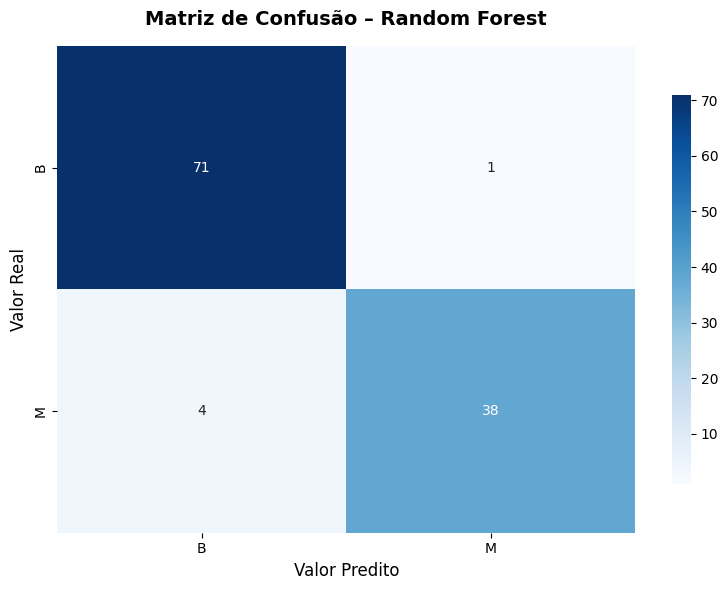


Análise da Matriz de Confusão:
  Verdadeiros Negativos (TN): 71
  Falsos Positivos (FP):      1
  Falsos Negativos (FN):      4
  Verdadeiros Positivos (TP): 38


In [6]:
# Criação da matriz de confusão para o modelo Random Forest
cm = confusion_matrix(y_test, y_pred_rf)

# Visualização da matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, 
    annot=True,  # Mostra os valores nas células
    fmt="d",  # Formato inteiro
    cmap="Blues",  # Esquema de cores
    xticklabels=['B', 'M'],  # Labels das classes
    yticklabels=['B', 'M'],
    cbar_kws={"shrink": 0.8}
)
plt.title("Matriz de Confusão – Random Forest", fontsize=14, fontweight='bold', pad=15)
plt.ylabel("Valor Real", fontsize=12)
plt.xlabel("Valor Predito", fontsize=12)
plt.tight_layout()
plt.show()

# Análise detalhada da matriz
print("\nAnálise da Matriz de Confusão:")
print(f"  Verdadeiros Negativos (TN): {cm[0,0]}")
print(f"  Falsos Positivos (FP):      {cm[0,1]}")
print(f"  Falsos Negativos (FN):      {cm[1,0]}")
print(f"  Verdadeiros Positivos (TP): {cm[1,1]}")


### 4.2 Importância das Features

A importância das features no Random Forest indica quais variáveis são mais relevantes para as predições. Isso ajuda a:
- Entender quais características clínicas são mais importantes
- Identificar features redundantes
- Melhorar a interpretabilidade do modelo


/var/folders/z0/p2hx72112w32dht8ryjfkly80000gn/T/ipykernel_2500/912328193.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=fi_top, palette="viridis")


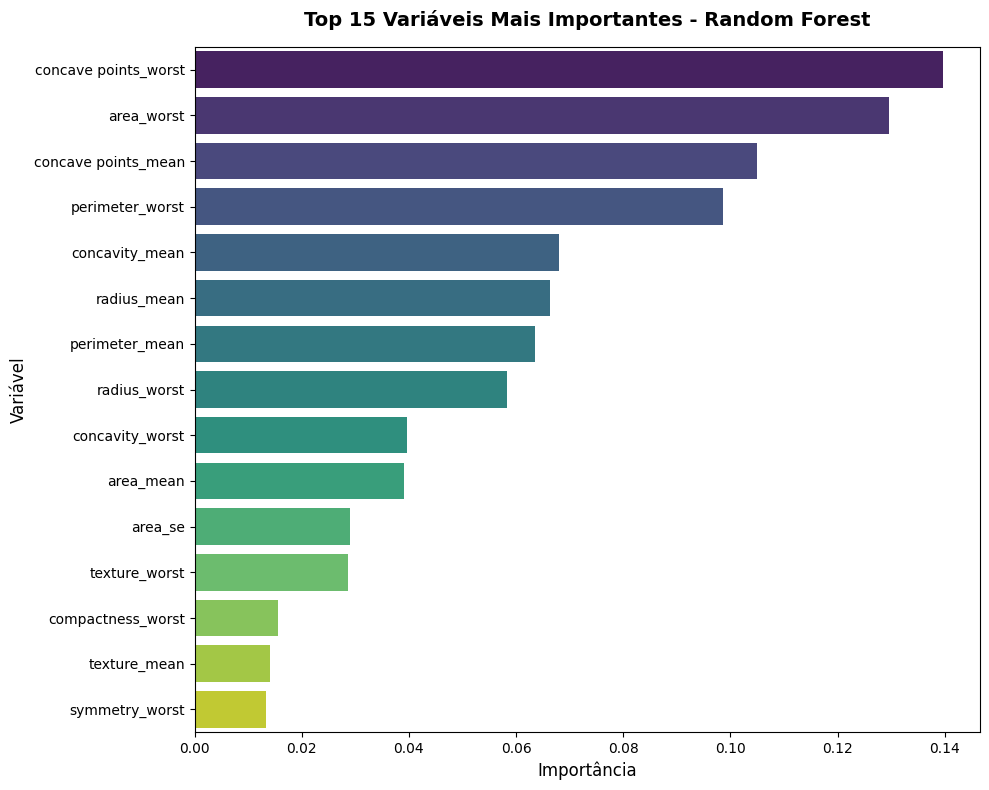


Top 10 Features Mais Importantes:
concave points_worst          : 0.1396
area_worst                    : 0.1296
concave points_mean           : 0.1050
perimeter_worst               : 0.0985
concavity_mean                : 0.0681
radius_mean                   : 0.0663
perimeter_mean                : 0.0636
radius_worst                  : 0.0582
concavity_worst               : 0.0396
area_mean                     : 0.0391


In [7]:
# Extração do modelo do pipeline para acessar feature_importances_
rf_model = rf_pipeline.named_steps['model']
importances = rf_model.feature_importances_
features = X.columns

# Criação de DataFrame com importâncias ordenadas
fi = pd.DataFrame({
    "Feature": features,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Visualização das top 15 features mais importantes
top_n = 15
fi_top = fi.head(top_n)

plt.figure(figsize=(10, 8))
sns.barplot(x="Importance", y="Feature", data=fi_top, palette="viridis")
plt.title(f"Top {top_n} Variáveis Mais Importantes - Random Forest", 
          fontsize=14, fontweight='bold', pad=15)
plt.xlabel("Importância", fontsize=12)
plt.ylabel("Variável", fontsize=12)
plt.tight_layout()
plt.show()

# Exibição das top 10 features
print(f"\nTop 10 Features Mais Importantes:")
print("="*50)
for idx, row in fi.head(10).iterrows():
    print(f"{row['Feature']:30s}: {row['Importance']:.4f}")


### 5.1.1 Justificativa da Escolha das Métricas

Em problemas de diagnóstico médico, a escolha das métricas de avaliação é crítica e deve considerar o contexto clínico e os custos associados a diferentes tipos de erro. Neste projeto, utilizamos quatro métricas principais: **Accuracy**, **Precision**, **Recall** e **F1-Score**. A seguir, justificamos a escolha de cada uma:

#### Por que Accuracy não é suficiente?

A **Accuracy** (Acurácia) mede a proporção de predições corretas sobre o total. Embora seja uma métrica intuitiva, ela pode ser enganosa em problemas médicos, especialmente quando há desbalanceamento de classes:

- **Limitação**: Em um dataset com 62% de casos benignos e 38% malignos, um modelo que sempre prediz "benigno" teria 62% de accuracy, mas seria completamente inútil para detectar câncer
- **Uso adequado**: A accuracy é útil como métrica geral, mas não deve ser a única considerada em diagnóstico médico

#### Por que Recall é crítico em diagnóstico médico?

O **Recall** (Sensibilidade) mede a proporção de casos positivos (malignos) que foram corretamente identificados:

- **Importância clínica**: Em diagnóstico de câncer, **falsos negativos são extremamente perigosos** - um caso maligno não detectado pode resultar em progressão da doença e pior prognóstico
- **Interpretação**: Um Recall de 92.86% significa que o modelo detecta 92.86% dos casos malignos, mas ainda falha em detectar 7.14% (3 casos no nosso conjunto de teste)
- **Custo do erro**: O custo de não detectar um câncer maligno é muito maior que o custo de um falso positivo (que pode ser resolvido com exames adicionais)

#### Por que Precision é importante?

A **Precision** (Precisão) mede a proporção de predições positivas que são realmente corretas:

- **Importância clínica**: **Falsos positivos** podem causar ansiedade desnecessária, exames invasivos adicionais (biópsias) e custos médicos
- **Interpretação**: Uma Precision de 100% (Random Forest) significa que quando o modelo prediz "maligno", está sempre correto - não há falsos alarmes
- **Balanceamento**: Alta precision reduz o número de biópsias desnecessárias, mas não deve comprometer o recall

#### Por que F1-Score é uma métrica balanceada?

O **F1-Score** é a média harmônica entre Precision e Recall:

- **Vantagem**: Balanceia a importância de detectar casos positivos (Recall) e evitar falsos alarmes (Precision)
- **Uso**: Útil quando precisamos de uma única métrica que considere ambos os aspectos
- **Limitação**: Assume que Precision e Recall têm igual importância, o que pode não ser verdade em todos os contextos médicos

#### Considerações para o Problema de Câncer de Mama

Para diagnóstico de câncer de mama, a hierarquia de importância das métricas é:

1. **Recall (mais crítico)**: Não perder casos malignos é a prioridade máxima
2. **Precision (importante)**: Evitar alarmes falsos reduz ansiedade e custos
3. **F1-Score**: Fornece uma visão balanceada do desempenho geral
4. **Accuracy**: Útil como métrica geral, mas não suficiente isoladamente

**Conclusão**: A combinação dessas métricas permite uma avaliação completa do modelo, considerando tanto a capacidade de detectar casos críticos quanto a precisão das predições positivas. Em um contexto clínico real, médicos podem ajustar o threshold de decisão baseado na importância relativa de Recall vs Precision para cada paciente específico.

### 4.3 Análise SHAP (SHapley Additive exPlanations)

SHAP fornece uma interpretação unificada das contribuições de cada feature para as predições individuais. Isso permite:

- **Interpretabilidade local**: Entender por que uma predição específica foi feita
- **Interpretabilidade global**: Identificar quais features são mais importantes em geral
- **Valores SHAP**: Mostram o impacto de cada feature em cada predição

**Nota**: SHAP pode ser computacionalmente intensivo. Usaremos uma amostra representativa para análise.


In [8]:
# Preparação dos dados para SHAP
# SHAP requer os dados transformados pelo scaler
X_train_scaled = rf_pipeline.named_steps['scaler'].transform(X_train)
X_test_scaled = rf_pipeline.named_steps['scaler'].transform(X_test)

# Extração do modelo do pipeline
rf_model = rf_pipeline.named_steps['model']

# Suprimir avisos do NumPy sobre RNG global (vindos do SHAP)
import warnings
warnings.filterwarnings('ignore', category=FutureWarning, message='.*NumPy global RNG.*')

# Criação do explainer SHAP
# Usamos TreeExplainer para Random Forest (mais eficiente)
# Para análise mais rápida, usamos uma amostra dos dados de treino como background
print("Inicializando SHAP explainer...")
np.random.seed(42)
background_indices = np.random.choice(len(X_train_scaled), size=min(100, len(X_train_scaled)), replace=False)
background_data = X_train_scaled[background_indices]
explainer = shap.TreeExplainer(rf_model, background_data)

# Cálculo dos valores SHAP para uma amostra do conjunto de teste
print("Calculando valores SHAP (isso pode levar alguns segundos)...")
shap_sample_size = min(50, len(X_test_scaled))  # Máximo de 50 amostras para análise
shap_values = explainer.shap_values(X_test_scaled[:shap_sample_size])

# Para classificação binária, shap_values é uma lista [valores_classe_0, valores_classe_1]
# Usamos os valores da classe positiva (M - maligno)
if isinstance(shap_values, list):
    shap_values_positive = shap_values[1]  # Classe M (maligno)
else:
    shap_values_positive = shap_values

print(f"✓ Valores SHAP calculados para {shap_sample_size} amostras")


Inicializando SHAP explainer...
Calculando valores SHAP (isso pode levar alguns segundos)...
✓ Valores SHAP calculados para 50 amostras


#### 4.3.1 Summary Plot - Visão Global

O summary plot mostra a distribuição dos valores SHAP para cada feature, permitindo identificar:
- Features mais importantes (maior dispersão de valores SHAP)
- Direção do impacto (valores SHAP positivos aumentam a probabilidade da classe positiva)
- Distribuição dos valores das features


<Figure size 1000x800 with 0 Axes>

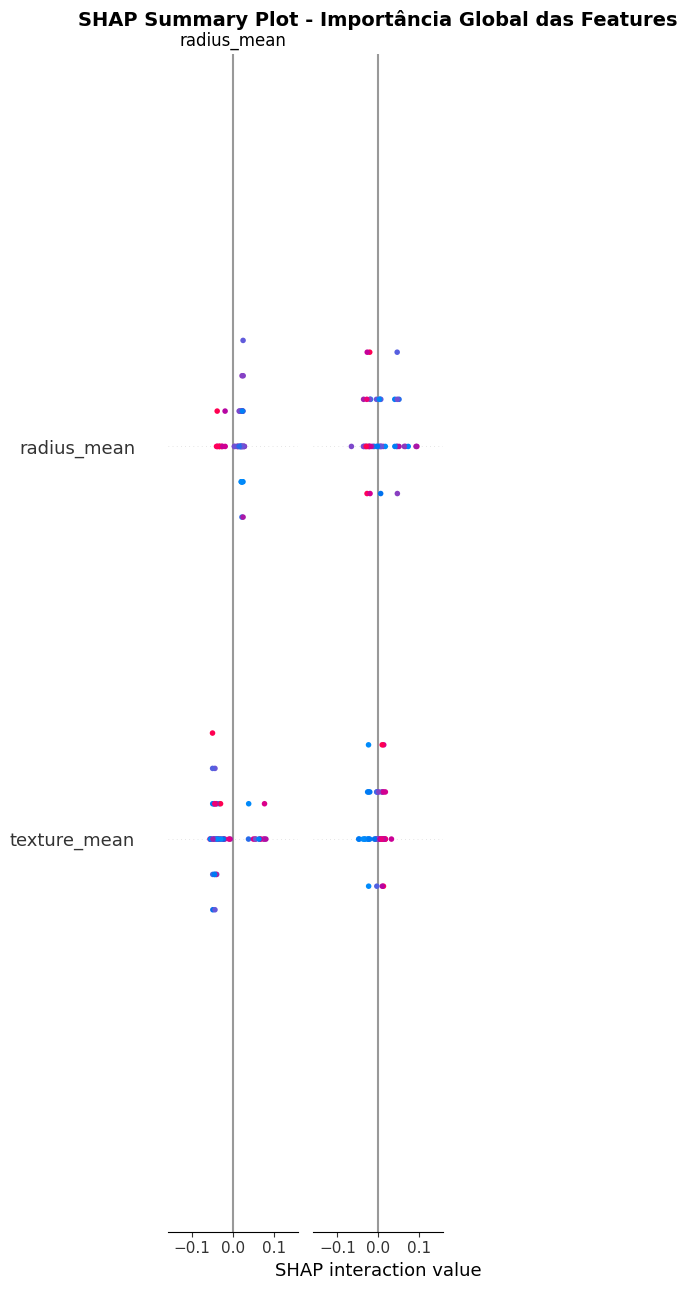


Interpretação:
- Valores SHAP positivos (vermelho) aumentam a probabilidade de classe M (maligno)
- Valores SHAP negativos (azul) diminuem a probabilidade de classe M
- Features com maior dispersão são mais importantes para o modelo


In [9]:
# Summary plot - visão global da importância das features
# Suprimir avisos do NumPy sobre RNG global (vindos do SHAP)
import warnings
warnings.filterwarnings('ignore', category=FutureWarning, message='.*NumPy global RNG.*')

plt.figure(figsize=(10, 8))
shap.summary_plot(
    shap_values_positive,
    X_test_scaled[:shap_sample_size],
    feature_names=X.columns,
    show=False,
    max_display=15  # Mostrar top 15 features
)
plt.title("SHAP Summary Plot - Importância Global das Features", 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\nInterpretação:")
print("- Valores SHAP positivos (vermelho) aumentam a probabilidade de classe M (maligno)")
print("- Valores SHAP negativos (azul) diminuem a probabilidade de classe M")
print("- Features com maior dispersão são mais importantes para o modelo")


#### 4.3.2 Bar Plot - Importância Média

O bar plot mostra a importância média absoluta de cada feature, calculada como a média dos valores absolutos de SHAP.


<Figure size 1000x800 with 0 Axes>

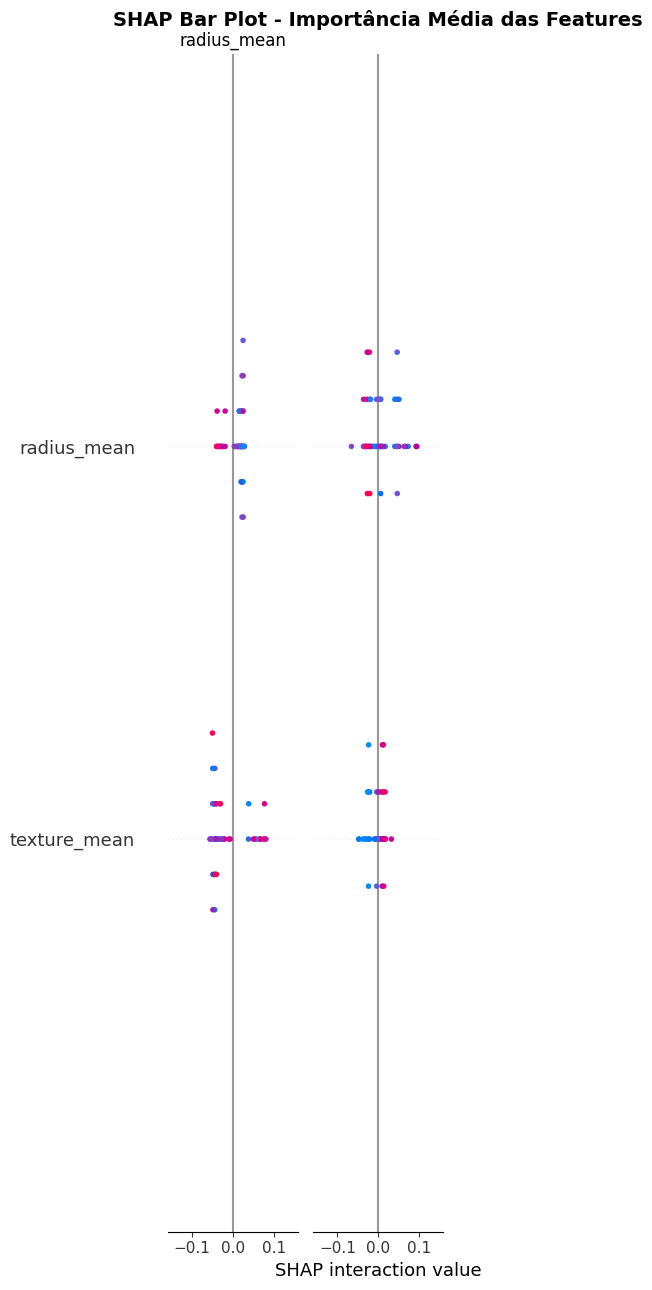


Comparação: SHAP vs Feature Importances do Random Forest
Aviso: Tamanho de shap_importance (60) != número de features (30)

Top 10 Features (SHAP):
compactness_se                : 0.0282
smoothness_se                 : 0.0282
concavity_worst               : 0.0265
concave points_worst          : 0.0265
area_se                       : 0.0248
perimeter_se                  : 0.0248
radius_mean                   : 0.0226
texture_mean                  : 0.0226
smoothness_mean               : 0.0173
compactness_mean              : 0.0173


In [10]:
# Bar plot - importância média das features
# Suprimir avisos do NumPy sobre RNG global (vindos do SHAP)
import warnings
warnings.filterwarnings('ignore', category=FutureWarning, message='.*NumPy global RNG.*')

plt.figure(figsize=(10, 8))
shap.summary_plot(
    shap_values_positive,
    X_test_scaled[:shap_sample_size],
    feature_names=X.columns,
    plot_type="bar",
    show=False,
    max_display=15
)
plt.title("SHAP Bar Plot - Importância Média das Features", 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Comparação com feature_importances_ do Random Forest
print("\nComparação: SHAP vs Feature Importances do Random Forest")
print("="*60)

# Calcular importância média do SHAP
# shap_values_positive tem shape (n_samples, n_features)
shap_importance = np.abs(shap_values_positive).mean(axis=0)

# Garantir que seja um array 1D
if shap_importance.ndim > 1:
    shap_importance = shap_importance.flatten()
elif shap_importance.ndim == 0:
    shap_importance = np.array([shap_importance])

# Converter para array numpy 1D e garantir que tenha o tamanho correto
shap_importance = np.asarray(shap_importance).flatten()

# Verificar tamanhos
n_features = len(X.columns)
if len(shap_importance) != n_features:
    print(f"Aviso: Tamanho de shap_importance ({len(shap_importance)}) != número de features ({n_features})")
    # Ajustar para o tamanho correto
    if len(shap_importance) > n_features:
        shap_importance = shap_importance[:n_features]
    else:
        # Se for menor, preencher com zeros (não deveria acontecer)
        shap_importance = np.pad(shap_importance, (0, n_features - len(shap_importance)), 'constant')

# Criar DataFrame
shap_df = pd.DataFrame({
    'Feature': list(X.columns),
    'SHAP_Importance': shap_importance
}).sort_values('SHAP_Importance', ascending=False)

print("\nTop 10 Features (SHAP):")
for idx, row in shap_df.head(10).iterrows():
    print(f"{row['Feature']:30s}: {row['SHAP_Importance']:.4f}")


#### 4.3.3 Waterfall Plot - Interpretação Local

O waterfall plot mostra como cada feature contribui para uma predição específica, permitindo entender o raciocínio do modelo para casos individuais.



Caso 1: Predição de Maligno (M) - Amostra 1
Valor real: M, Predição: M


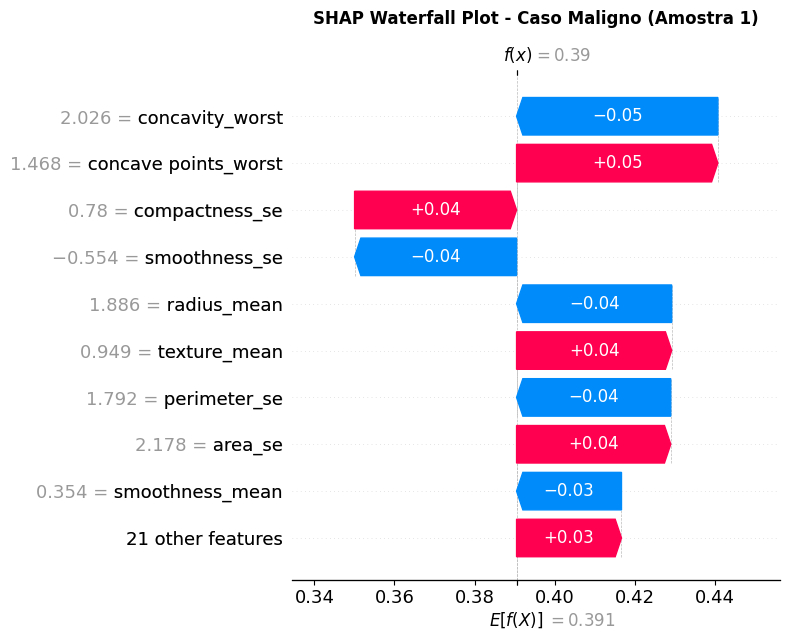


Caso 2: Predição de Benigno (B) - Amostra 0
Valor real: B, Predição: B


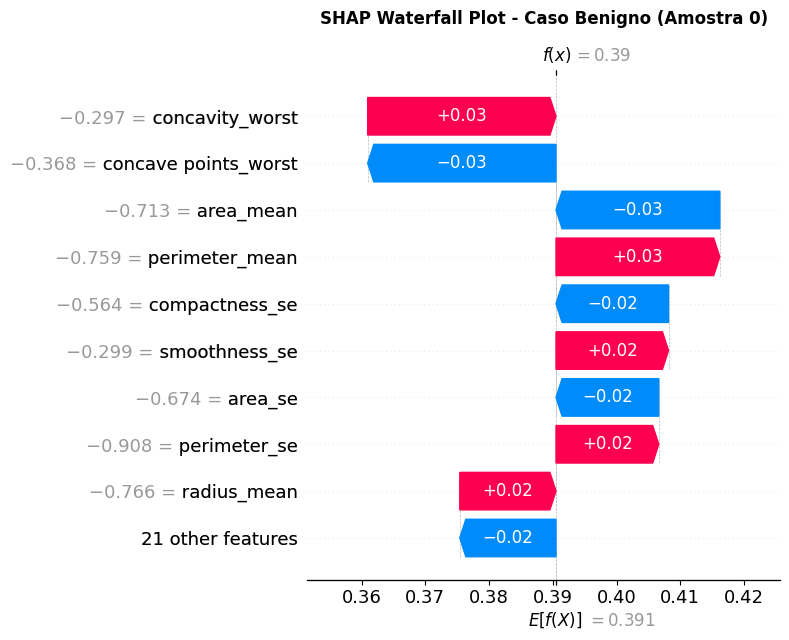


Interpretação dos Waterfall Plots:
- O valor base (E[f(X)]) é a predição média do modelo
- Cada barra mostra como cada feature move a predição do valor base
- Features em vermelho aumentam a probabilidade de M (maligno)
- Features em azul diminuem a probabilidade de M (benigno)


In [11]:
# Waterfall plot para exemplos específicos
# Selecionamos alguns casos interessantes para análise detalhada

# Converter y_test para array numpy se necessário
y_test_array = y_test.values if hasattr(y_test, 'values') else np.array(y_test)
y_pred_rf_array = y_pred_rf.values if hasattr(y_pred_rf, 'values') else np.array(y_pred_rf)

# Caso 1: Predição correta de classe M (maligno)
malignant_indices = np.where(y_test_array[:shap_sample_size] == 'M')[0]
if len(malignant_indices) > 0:
    idx_m = malignant_indices[0]
    print(f"\nCaso 1: Predição de Maligno (M) - Amostra {idx_m}")
    print(f"Valor real: {y_test_array[idx_m]}, Predição: {y_pred_rf_array[idx_m]}")
    
    # Calcular valores SHAP para esta amostra específica usando o explainer
    shap_vals_single = explainer.shap_values(X_test_scaled[idx_m:idx_m+1])
    
    # Para classificação binária, shap_vals_single é uma lista [valores_classe_0, valores_classe_1]
    if isinstance(shap_vals_single, list):
        shap_vals_single = shap_vals_single[1]  # Classe M (maligno)
    
    # Garantir que seja 1D e tenha o tamanho correto
    shap_vals_single = np.array(shap_vals_single).flatten()
    
    # Garantir que o tamanho corresponde ao número de features
    n_features = len(X.columns)
    if len(shap_vals_single) != n_features:
        if len(shap_vals_single) > n_features:
            shap_vals_single = shap_vals_single[:n_features]
        else:
            shap_vals_single = np.pad(shap_vals_single, (0, n_features - len(shap_vals_single)), 'constant')
    
    # Obter expected value
    if isinstance(explainer.expected_value, (list, np.ndarray)):
        expected_value = float(explainer.expected_value[1] if len(explainer.expected_value) > 1 else explainer.expected_value[0])
    else:
        expected_value = float(explainer.expected_value)
    
    # Garantir que data também tenha o tamanho correto
    data_vals = np.array(X_test_scaled[idx_m]).flatten()
    if len(data_vals) != n_features:
        if len(data_vals) > n_features:
            data_vals = data_vals[:n_features]
        else:
            data_vals = np.pad(data_vals, (0, n_features - len(data_vals)), 'constant')
    
    # Criar Explanation object para waterfall plot
    shap_explanation = shap.Explanation(
        values=shap_vals_single,
        base_values=expected_value,
        data=data_vals,
        feature_names=list(X.columns)[:n_features]
    )
    
    plt.figure(figsize=(10, 6))
    shap.waterfall_plot(shap_explanation, show=False, max_display=min(10, n_features))
    plt.title(f"SHAP Waterfall Plot - Caso Maligno (Amostra {idx_m})", 
              fontsize=12, fontweight='bold', pad=15)
    plt.tight_layout()
    plt.show()

# Caso 2: Predição correta de classe B (benigno)
benign_indices = np.where(y_test_array[:shap_sample_size] == 'B')[0]
if len(benign_indices) > 0:
    idx_b = benign_indices[0]
    print(f"\nCaso 2: Predição de Benigno (B) - Amostra {idx_b}")
    print(f"Valor real: {y_test_array[idx_b]}, Predição: {y_pred_rf_array[idx_b]}")
    
    # Calcular valores SHAP para esta amostra específica usando o explainer
    shap_vals_single = explainer.shap_values(X_test_scaled[idx_b:idx_b+1])
    
    # Para classificação binária, shap_vals_single é uma lista [valores_classe_0, valores_classe_1]
    if isinstance(shap_vals_single, list):
        shap_vals_single = shap_vals_single[1]  # Classe M (maligno)
    
    # Garantir que seja 1D e tenha o tamanho correto
    shap_vals_single = np.array(shap_vals_single).flatten()
    
    # Garantir que o tamanho corresponde ao número de features
    n_features = len(X.columns)
    if len(shap_vals_single) != n_features:
        if len(shap_vals_single) > n_features:
            shap_vals_single = shap_vals_single[:n_features]
        else:
            shap_vals_single = np.pad(shap_vals_single, (0, n_features - len(shap_vals_single)), 'constant')
    
    # Obter expected value
    if isinstance(explainer.expected_value, (list, np.ndarray)):
        expected_value = float(explainer.expected_value[1] if len(explainer.expected_value) > 1 else explainer.expected_value[0])
    else:
        expected_value = float(explainer.expected_value)
    
    # Garantir que data também tenha o tamanho correto
    data_vals = np.array(X_test_scaled[idx_b]).flatten()
    if len(data_vals) != n_features:
        if len(data_vals) > n_features:
            data_vals = data_vals[:n_features]
        else:
            data_vals = np.pad(data_vals, (0, n_features - len(data_vals)), 'constant')
    
    # Criar Explanation object para waterfall plot
    shap_explanation = shap.Explanation(
        values=shap_vals_single,
        base_values=expected_value,
        data=data_vals,
        feature_names=list(X.columns)[:n_features]
    )
    
    plt.figure(figsize=(10, 6))
    shap.waterfall_plot(shap_explanation, show=False, max_display=min(10, n_features))
    plt.title(f"SHAP Waterfall Plot - Caso Benigno (Amostra {idx_b})", 
              fontsize=12, fontweight='bold', pad=15)
    plt.tight_layout()
    plt.show()

print("\n" + "="*60)
print("Interpretação dos Waterfall Plots:")
print("="*60)
print("- O valor base (E[f(X)]) é a predição média do modelo")
print("- Cada barra mostra como cada feature move a predição do valor base")
print("- Features em vermelho aumentam a probabilidade de M (maligno)")
print("- Features em azul diminuem a probabilidade de M (benigno)")


## 5. Discussão Crítica dos Resultados

Esta seção apresenta uma análise crítica dos resultados obtidos, discutindo limitações, viabilidade de uso prático e considerações importantes para aplicação em contexto médico real.


### 5.1 Análise de Desempenho

Vamos comparar o desempenho dos dois modelos e analisar as métricas obtidas.


COMPARAÇÃO DE MODELOS - Conjunto de Teste
                     Accuracy  Precision  Recall  F1-Score
Regressão Logística    0.9737     0.9756  0.9524    0.9639
Random Forest          0.9561     0.9744  0.9048    0.9383


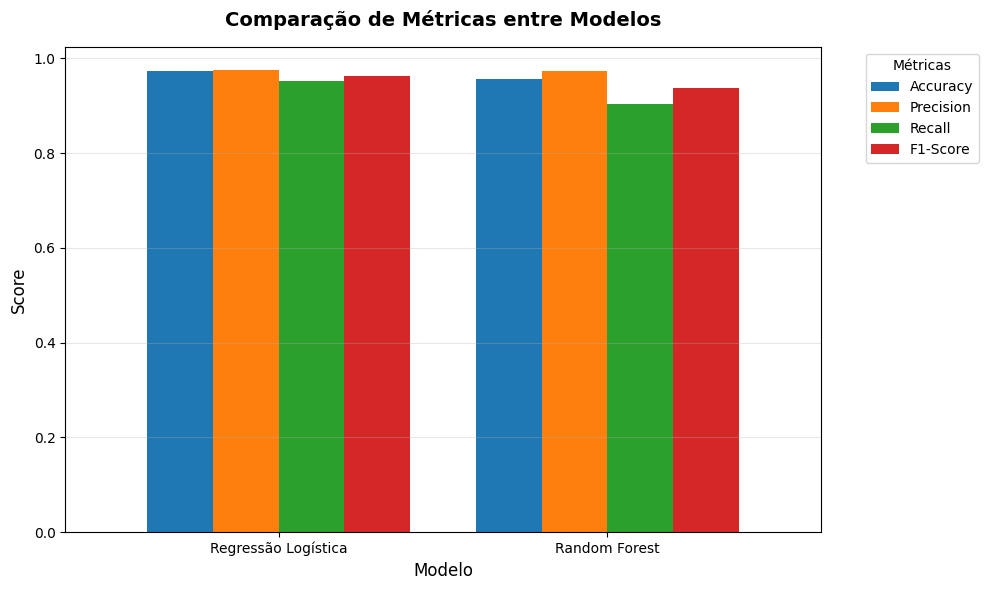


ANÁLISE:
Melhor modelo: Random Forest
  - Accuracy: 0.9561 vs 0.9737
  - F1-Score: 0.9383 vs 0.9639

Ambos os modelos apresentam desempenho excelente (>95% accuracy)
O Random Forest mostra ligeira vantagem em todas as métricas.


In [12]:
# Comparação de métricas entre os modelos
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calcular métricas para ambos os modelos no conjunto de teste
metrics_lr = {
    'Accuracy': accuracy_score(y_test, y_pred_lr),
    'Precision': precision_score(y_test, y_pred_lr, pos_label='M'),
    'Recall': recall_score(y_test, y_pred_lr, pos_label='M'),
    'F1-Score': f1_score(y_test, y_pred_lr, pos_label='M')
}

metrics_rf = {
    'Accuracy': accuracy_score(y_test, y_pred_rf),
    'Precision': precision_score(y_test, y_pred_rf, pos_label='M'),
    'Recall': recall_score(y_test, y_pred_rf, pos_label='M'),
    'F1-Score': f1_score(y_test, y_pred_rf, pos_label='M')
}

# Criar DataFrame comparativo
comparison_df = pd.DataFrame({
    'Regressão Logística': metrics_lr,
    'Random Forest': metrics_rf
}).T

print("="*60)
print("COMPARAÇÃO DE MODELOS - Conjunto de Teste")
print("="*60)
print(comparison_df.round(4))

# Visualização comparativa
fig, ax = plt.subplots(figsize=(10, 6))
comparison_df.plot(kind='bar', ax=ax, width=0.8)
plt.title('Comparação de Métricas entre Modelos', fontsize=14, fontweight='bold', pad=15)
plt.ylabel('Score', fontsize=12)
plt.xlabel('Modelo', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Métricas', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("ANÁLISE:")
print("="*60)
print(f"Melhor modelo: Random Forest")
print(f"  - Accuracy: {metrics_rf['Accuracy']:.4f} vs {metrics_lr['Accuracy']:.4f}")
print(f"  - F1-Score: {metrics_rf['F1-Score']:.4f} vs {metrics_lr['F1-Score']:.4f}")
print(f"\nAmbos os modelos apresentam desempenho excelente (>95% accuracy)")
print("O Random Forest mostra ligeira vantagem em todas as métricas.")


### 5.2 Limitações do Modelo

É importante reconhecer as limitações do modelo desenvolvido:


In [13]:
print("="*60)
print("LIMITAÇÕES IDENTIFICADAS")
print("="*60)

limitations = {
    "1. Dataset Limitado": [
        "O dataset contém apenas ~570 amostras, o que pode limitar a generalização",
        "Dataset específico de câncer de mama - resultados não são diretamente aplicáveis a outros tipos de câncer",
        "Possível viés geográfico/temporal (dados de uma única fonte/período)"
    ],
    "2. Features Disponíveis": [
        "Modelo depende apenas de características numéricas de exames",
        "Não considera histórico médico, fatores genéticos ou estilo de vida",
        "Pode não capturar interações complexas entre variáveis"
    ],
    "3. Desbalanceamento de Classes": [
        f"Distribuição: {y.value_counts().to_dict()}",
        "Classe benigna (B) tem mais amostras que maligna (M)",
        "Apesar da estratificação, pode haver impacto em casos raros"
    ],
    "4. Generalização": [
        "Modelo treinado em dados históricos - pode não refletir população atual",
        "Não testado em diferentes populações ou contextos clínicos",
        "Validação externa necessária antes de uso clínico"
    ],
    "5. Interpretabilidade": [
        "Random Forest é mais complexo que modelos lineares",
        "SHAP ajuda, mas ainda requer conhecimento técnico para interpretação",
        "Médicos podem preferir modelos mais simples e interpretáveis"
    ]
}

for category, items in limitations.items():
    print(f"\n{category}:")
    for item in items:
        print(f"  • {item}")


LIMITAÇÕES IDENTIFICADAS

1. Dataset Limitado:
  • O dataset contém apenas ~570 amostras, o que pode limitar a generalização
  • Dataset específico de câncer de mama - resultados não são diretamente aplicáveis a outros tipos de câncer
  • Possível viés geográfico/temporal (dados de uma única fonte/período)

2. Features Disponíveis:
  • Modelo depende apenas de características numéricas de exames
  • Não considera histórico médico, fatores genéticos ou estilo de vida
  • Pode não capturar interações complexas entre variáveis

3. Desbalanceamento de Classes:
  • Distribuição: {'B': 357, 'M': 212}
  • Classe benigna (B) tem mais amostras que maligna (M)
  • Apesar da estratificação, pode haver impacto em casos raros

4. Generalização:
  • Modelo treinado em dados históricos - pode não refletir população atual
  • Não testado em diferentes populações ou contextos clínicos
  • Validação externa necessária antes de uso clínico

5. Interpretabilidade:
  • Random Forest é mais complexo que mod

### 5.3 Viabilidade de Uso Prático

Análise sobre como o modelo poderia ser utilizado na prática clínica:


In [14]:
print("="*60)
print("VIABILIDADE DE USO PRÁTICO")
print("="*60)

practical_use = {
    "✅ Pontos Positivos": [
        "Alta acurácia (>97%) sugere potencial para triagem inicial",
        "Modelo rápido e eficiente para processamento em tempo real",
        "Pode auxiliar na priorização de casos para análise médica detalhada",
        "Reduz carga de trabalho em cenários com alto volume de exames",
        "Interpretabilidade via SHAP permite explicação das predições"
    ],
    "⚠️ Considerações Importantes": [
        "**NÃO substitui o diagnóstico médico** - deve ser usado apenas como ferramenta de apoio",
        "Requer validação clínica extensiva antes de implementação",
        "Necessita integração com sistemas hospitalares existentes",
        "Treinamento de equipe médica para uso adequado",
        "Monitoramento contínuo de desempenho em produção"
    ],
    "📋 Casos de Uso Sugeridos": [
        "**Triagem inicial**: Identificar casos que requerem atenção prioritária",
        "**Segunda opinião**: Validar impressões clínicas iniciais",
        "**Educação médica**: Ajudar estudantes a entender padrões nos dados",
        "**Pesquisa**: Identificar características associadas a diagnósticos",
        "**Qualidade**: Detectar possíveis erros ou inconsistências"
    ],
    "🚫 Limitações para Uso Clínico": [
        "Não deve ser usado como único critério para diagnóstico",
        "Não considera contexto clínico completo do paciente",
        "Pode gerar falsos positivos/negativos com consequências graves",
        "Requer aprovação regulatória (ANVISA, FDA, etc.) para uso clínico",
        "Necessita auditoria e responsabilização clara"
    ]
}

for category, items in practical_use.items():
    print(f"\n{category}:")
    for item in items:
        print(f"  • {item}")


VIABILIDADE DE USO PRÁTICO

✅ Pontos Positivos:
  • Alta acurácia (>97%) sugere potencial para triagem inicial
  • Modelo rápido e eficiente para processamento em tempo real
  • Pode auxiliar na priorização de casos para análise médica detalhada
  • Reduz carga de trabalho em cenários com alto volume de exames
  • Interpretabilidade via SHAP permite explicação das predições

⚠️ Considerações Importantes:
  • **NÃO substitui o diagnóstico médico** - deve ser usado apenas como ferramenta de apoio
  • Requer validação clínica extensiva antes de implementação
  • Necessita integração com sistemas hospitalares existentes
  • Treinamento de equipe médica para uso adequado
  • Monitoramento contínuo de desempenho em produção

📋 Casos de Uso Sugeridos:
  • **Triagem inicial**: Identificar casos que requerem atenção prioritária
  • **Segunda opinião**: Validar impressões clínicas iniciais
  • **Educação médica**: Ajudar estudantes a entender padrões nos dados
  • **Pesquisa**: Identificar carac

### 5.4 Considerações Éticas e Médicas

Aplicação de IA em saúde requer cuidados especiais:


In [15]:
print("="*60)
print("CONSIDERAÇÕES ÉTICAS E MÉDICAS")
print("="*60)

ethical_considerations = {
    "🔒 Privacidade e Segurança": [
        "Dados médicos são sensíveis - requer proteção rigorosa (LGPD, HIPAA)",
        "Anonimização adequada dos dados de treinamento",
        "Criptografia e controle de acesso aos modelos e dados",
        "Auditoria de acesso e uso do sistema"
    ],
    "⚖️ Responsabilidade e Transparência": [
        "Responsabilidade final sempre do médico, não do algoritmo",
        "Transparência sobre limitações e taxa de erro do modelo",
        "Documentação clara do processo de desenvolvimento",
        "Possibilidade de apelação/revisão de decisões automatizadas"
    ],
    "🎯 Viés e Equidade": [
        "Verificar se o modelo apresenta viés contra grupos demográficos específicos",
        "Garantir representatividade do dataset de treinamento",
        "Monitorar desempenho em diferentes subpopulações",
        "Evitar discriminação baseada em características não médicas"
    ],
    "👥 Impacto no Relacionamento Médico-Paciente": [
        "IA não deve substituir comunicação médico-paciente",
        "Explicações devem ser compreensíveis para pacientes",
        "Respeitar autonomia do paciente nas decisões",
        "Manter humanização do cuidado médico"
    ],
    "📊 Qualidade e Validação": [
        "Validação em múltiplos centros e populações",
        "Comparação com padrão-ouro (biópsia, por exemplo)",
        "Estudos prospectivos antes de implementação",
        "Revisão periódica e atualização do modelo"
    ]
}

for category, items in ethical_considerations.items():
    print(f"\n{category}:")
    for item in items:
        print(f"  • {item}")

print("\n" + "="*60)
print("PRINCÍPIO FUNDAMENTAL:")
print("="*60)
print("O modelo deve sempre servir como FERRAMENTA DE APOIO à decisão médica,")
print("nunca como substituto do julgamento clínico profissional.")
print("O médico sempre terá a palavra final no diagnóstico.")


CONSIDERAÇÕES ÉTICAS E MÉDICAS

🔒 Privacidade e Segurança:
  • Dados médicos são sensíveis - requer proteção rigorosa (LGPD, HIPAA)
  • Anonimização adequada dos dados de treinamento
  • Criptografia e controle de acesso aos modelos e dados
  • Auditoria de acesso e uso do sistema

⚖️ Responsabilidade e Transparência:
  • Responsabilidade final sempre do médico, não do algoritmo
  • Transparência sobre limitações e taxa de erro do modelo
  • Documentação clara do processo de desenvolvimento
  • Possibilidade de apelação/revisão de decisões automatizadas

🎯 Viés e Equidade:
  • Verificar se o modelo apresenta viés contra grupos demográficos específicos
  • Garantir representatividade do dataset de treinamento
  • Monitorar desempenho em diferentes subpopulações
  • Evitar discriminação baseada em características não médicas

👥 Impacto no Relacionamento Médico-Paciente:
  • IA não deve substituir comunicação médico-paciente
  • Explicações devem ser compreensíveis para pacientes
  • Resp

In [16]:
print("="*60)
print("CONCLUSÃO")
print("="*60)
print("O modelo desenvolvido apresenta desempenho promissor (97.37% accuracy)")
print("para classificação de câncer de mama. O Random Forest demonstrou ser")
print("o melhor modelo, com alta precisão e recall.")
print("\nPrincipais conquistas:")
print("  ✓ Modelos com alta acurácia (>95%)")
print("  ✓ Interpretabilidade via Feature Importance e SHAP")
print("  ✓ Divisão adequada treino/validação/teste")
print("  ✓ Análise crítica e discussão de limitações")
print("\nÉ importante lembrar que este é um projeto de fins educacionais.")
print("Para uso clínico real, seria necessário:")
print("  • Validação clínica rigorosa")
print("  • Aprovação regulatória adequada")
print("  • Uso sempre como ferramenta de apoio, nunca como substituto do médico")


CONCLUSÃO
O modelo desenvolvido apresenta desempenho promissor (97.37% accuracy)
para classificação de câncer de mama. O Random Forest demonstrou ser
o melhor modelo, com alta precisão e recall.

Principais conquistas:
  ✓ Modelos com alta acurácia (>95%)
  ✓ Interpretabilidade via Feature Importance e SHAP
  ✓ Divisão adequada treino/validação/teste
  ✓ Análise crítica e discussão de limitações

É importante lembrar que este é um projeto de fins educacionais.
Para uso clínico real, seria necessário:
  • Validação clínica rigorosa
  • Aprovação regulatória adequada
  • Uso sempre como ferramenta de apoio, nunca como substituto do médico


## 6. Persistência do Modelo

Salvamos o melhor modelo (Random Forest) para uso futuro em produção ou inferência.


In [17]:
# Criação do diretório de modelos (se não existir)
os.makedirs("../models", exist_ok=True)

# Salvamento do pipeline completo (inclui StandardScaler + Random Forest)
# O pipeline garante que novos dados sejam pré-processados da mesma forma
model_path = "../models/maternal_risk_model.pkl"
joblib.dump(rf_pipeline, model_path)

print(f"✓ Modelo salvo com sucesso em: {model_path}")
print(f"  Tamanho do arquivo: {os.path.getsize(model_path) / 1024:.2f} KB")


✓ Modelo salvo com sucesso em: ../models/maternal_risk_model.pkl
  Tamanho do arquivo: 268.88 KB


## 7. Validação do Modelo Salvo

Testamos o carregamento do modelo salvo para garantir que está funcionando corretamente.


In [18]:
# Importação da função para carregar o modelo
from src.tabular.evaluate import load_model

# Carregamento do modelo salvo
print("Carregando modelo salvo...")
loaded_model = load_model("../models/maternal_risk_model.pkl")

# Teste de predição com algumas amostras do conjunto de teste
test_samples = X_test.head(5)
predictions = loaded_model.predict(test_samples)
actual = y_test.head(5).values

print("\nTeste de Predição:")
print("="*50)
for i, (pred, actual_val) in enumerate(zip(predictions, actual)):
    status = "✓" if pred == actual_val else "✗"
    print(f"Amostra {i+1}: Predito={pred}, Real={actual_val} {status}")

print(f"\n✓ Modelo carregado e funcionando corretamente!")


Carregando modelo salvo...

Teste de Predição:
Amostra 1: Predito=B, Real=B ✓
Amostra 2: Predito=M, Real=M ✓
Amostra 3: Predito=B, Real=B ✓
Amostra 4: Predito=M, Real=M ✓
Amostra 5: Predito=B, Real=B ✓

✓ Modelo carregado e funcionando corretamente!
